In [1]:
suppressPackageStartupMessages(suppressWarnings({
    library("ggplot2")
    library(dplyr)
    library(tidyr)
    library(ComplexHeatmap)
    library(tibble)
    library(RColorBrewer) 
    library(scales)
    library(circlize)
    library(patchwork)
}))
source("../../../utils/r_themes.r")


In [2]:
profile_file_path <- file.path("../../data/CP_feature_select/profiles/features_selected_profile.parquet")
figure_path <- file.path("../figures/")
if (!dir.exists(figure_path)) {
    dir.create(figure_path, recursive = TRUE)
}

In [3]:
profile_file_path <- file.path("../../../data/CP_aggregated/profiles/aggregated_profile.parquet")
cell_count_file_path <- file.path(
    "../../../2.cell_tracks_data/data/combined_stats.parquet"
)
df <- arrow::read_parquet(profile_file_path) %>% arrange(Metadata_Well)
cell_count_df <- arrow::read_parquet(cell_count_file_path)
# transform the data to standard scalar (-1, 1) format 
for (i in 1:ncol(df)) {
    # make sure the column is not metadata
    if (grepl("Metadata_", colnames(df)[i])) {
        next
    }
    if (is.numeric(df[[i]])) {
        df[[i]] <- rescale(df[[i]], to = c(-1, 1))
    }
}
# map each of the Time points to the actual timepoint
df$Metadata_Time <- as.numeric(df$Metadata_Time * 60 /2 )
head(df)

Metadata_Well,Metadata_Time,Metadata_number_of_singlecells,Metadata_plate,Metadata_compound,Metadata_dose,Metadata_control,Cytoplasm_AreaShape_Area,Cytoplasm_AreaShape_Compactness,Cytoplasm_AreaShape_Eccentricity,⋯,Nuclei_Texture_DifferenceVariance_CL_488_1_3_00_256,Nuclei_Texture_DifferenceVariance_CL_488_2_3_01_256,Nuclei_Texture_DifferenceVariance_CL_561_3_02_256,Nuclei_Texture_InverseDifferenceMoment_CL_488_1_3_01_256,Nuclei_Texture_InverseDifferenceMoment_CL_561_3_01_256,Nuclei_Texture_InverseDifferenceMoment_DNA_3_00_256,Nuclei_Texture_SumAverage_CL_488_1_3_01_256,Nuclei_Texture_SumAverage_CL_488_2_3_03_256,Nuclei_Texture_SumAverage_CL_561_3_03_256,Nuclei_Texture_SumAverage_DNA_3_00_256
<chr>,<dbl>,<dbl>,<int>,<chr>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
C-02,0,178,1,Staurosporine,0,negative,-0.3077931,-0.23793229,0.3326490,⋯,0.1685810,0.9092665,0.41315863,0.6149466,0.9041545,1,-0.8486876,0.5800995,0.6265737,-1
C-02,30,181,1,Staurosporine,0,negative,0.1525868,-0.03225952,-0.2848193,⋯,0.6410666,1.0000000,0.05164955,0.7862659,0.7851227,1,-0.9088725,0.5800995,0.7598132,-1
C-02,60,184,1,Staurosporine,0,negative,0.1954813,-0.01050981,0.2037379,⋯,0.7055249,0.8238723,-0.03361966,0.8374437,0.7671486,1,-0.9383707,0.5800995,0.7749237,-1
C-02,90,180,1,Staurosporine,0,negative,0.2134905,0.09698605,0.5325356,⋯,0.7019467,0.4909525,-0.10675462,0.8545964,0.7382491,1,-0.9436782,0.5800995,0.8186410,-1
C-02,120,176,1,Staurosporine,0,negative,0.2979699,0.15645764,0.7277458,⋯,0.5684930,-0.3483149,-0.15435188,0.7514948,0.7326582,1,-0.9367073,0.5800995,0.8140134,-1
C-02,150,173,1,Staurosporine,0,negative,0.3497053,0.25993120,0.9116416,⋯,0.5832146,-0.7056590,-0.16671863,0.7879789,0.7021143,1,-0.9573781,0.5800995,0.8246841,-1


In [4]:
cell_count_df$Metadata_dose <- as.character(cell_count_df$Metadata_dose)
cell_count_df$Metadata_dose <- factor(
    cell_count_df$Metadata_dose, 
    levels = c(
        '0',
        '0.61',
        '1.22',
        '2.44',
        '4.88',
        '9.77',
        '19.53',
        '39.06',
        '78.13',
        '156.25'
    )
)
cell_count_df$Metadata_Time <- as.numeric(cell_count_df$Metadata_Time) * 30


In [5]:
# get the well from the well_fov column, get the first part of the string
# before the underscore and number
cell_count_df$well <- sub("_.*", "", cell_count_df$well_fov)
cell_count_df$Metadata_Well <- sub("_.*", "", cell_count_df$well_fov)

In [6]:
# get the counts of cells per timepoint per well
cell_count_df <- cell_count_df %>% 
    group_by(Metadata_Time, Metadata_Well, Metadata_dose) %>%
    summarise(
        cell_count = sum(total_CP_cells),
        .groups = "drop"
    )

In [7]:
# merge the cell count df with the profile df to get the dose information
df <- df %>%
    left_join(
        cell_count_df %>% select(Metadata_Well, Metadata_Time,cell_count) %>% distinct(),
        by = c("Metadata_Well", "Metadata_Time")
    )
df$Metadata_cell_count <- df$cell_count
# drop cell_count column
df <- df %>% select(-cell_count)


In [8]:
metadata_cols <- grep("Metadata_", colnames(df), value = TRUE)

In [9]:
# complex heatmap does not compare across heatmaps the scale so we must set it manually
# for more information see:
# https://github.com/jokergoo/EnrichedHeatmap/issues/7

# we will set the color scale the same way that ComplexHeatmap does
# The automatically generated colors map from the minus and plus 99^th of
# the absolute values in the matrix.


global_across_dose_99th_min <- df %>% 
    select(-metadata_cols) %>%
    summarise(across(everything(), ~ quantile((.), 0.01, na.rm = TRUE))) %>%
    unlist() %>%
    min(na.rm = TRUE)
global_across_dose_99th_max <- df %>%
    select(-metadata_cols) %>%
    summarise(across(everything(), ~ quantile((.), 0.99, na.rm = TRUE))) %>%
    unlist() %>%
    max(na.rm = TRUE)

print(global_across_dose_99th_min)
print(global_across_dose_99th_max)
col_fun = circlize::colorRamp2(c(global_across_dose_99th_min, 0, global_across_dose_99th_max), c("blue","white", "red"))

Note: Using an external vector in selections is ambiguous.
ℹ Use `all_of(metadata_cols)` instead of `metadata_cols` to silence this message.
ℹ See <https://tidyselect.r-lib.org/reference/faq-external-vector.html>.
This message is displayed once per session.


[1] -1
[1] 1


In [10]:
# get the list of features
features <- colnames(df)
metadata_cols <- grep("Metadata_", colnames(df), value = TRUE)
features <- features[!features %in% metadata_cols]
features <- as.data.frame(features)
# split the features by _ into multiple columns
features <- features %>% 
    separate(features, into = c("Compartment", "Measurement", "Metric", "Extra", "Extra1", "Extra2", "Extra3"), sep = "_", extra = "merge", fill = "right")
# clean up the features columns
# if Extra is NA then replace with None
features$Extra[is.na(features$Extra)] <- "None"
# if extra is a number then replace with None
features$Extra[grepl("^[0-9]+$", features$Extra)] <- "None"
# replace all other NAs with None
features$Extra1[is.na(features$Extra1)] <- "None"
features$Extra2[is.na(features$Extra2)] <- "None"
# change extra to None if X or Y
features$Extra[features$Extra == "X"] <- "None"
features$Extra[features$Extra == "Y"] <- "None"
# drop the Adjacent channel
features$Extra[features$Extra == "Adjacent"] <- "None"
# if extra1 is 488 then add extra2 to Extra1
features$Extra1[features$Extra1 == "488"] <- paste0(features$Extra1[features$Extra1 == "488"], "_", features$Extra2[features$Extra1 == "488"])
# if extra1 id CL then add extra1 to Extra
features$Extra[features$Extra == "CL"] <- paste0(features$Extra[features$Extra == "CL"], "_", features$Extra1[features$Extra == "CL"])

features <- features %>% 
    rename(Channel = Extra) %>%
    select(-Extra1, -Extra2)
# rename channel names to replace "_" with " "
features$Channel <- gsub("CL_488_1", "CL 488_1", features$Channel)
features$Channel <- gsub("CL_488_2", "CL 488_2", features$Channel)
features$Channel <- gsub("CL_561", "CL 561", features$Channel)

# time color function
time_col_fun = colorRamp2(
    c(min(unique(df$Metadata_Time)), max(unique(df$Metadata_Time))), c("white", "purple")
    )

cell_counts <- df$Metadata_cell_count
cell_count_col_fun = colorRamp2(
    c(min(cell_counts, na.rm = TRUE), max(cell_counts, na.rm = TRUE)), c("white", "darkgreen")
    )

column_anno <- HeatmapAnnotation(
    # make the annotation on the bottom

    Time = unique(df$Metadata_Time),
    show_legend = TRUE,
    annotation_name_gp = gpar(fontsize = 2),
    annotation_legend_param = list(
        title_position = "topcenter", 
        title_gp = gpar(fontsize = 16, angle = 0, fontface = "bold", hjust = 1.0),
        labels_gp = gpar(fontsize = 16, 
        title = gpar(fontsize = 16))
        ),
    
    col = list(
        Time = time_col_fun
    )
)
# compartment row annotation
row_compartment = rowAnnotation(
    Object = features$Compartment,
        show_legend = TRUE,
    # change the legend titles
    annotation_legend_param = list(
        title_position = "topcenter", 
        title_gp = gpar(fontsize = 16, angle = 0, fontface = "bold", hjust = 1.0),
        labels_gp = gpar(fontsize = 16, 
        title = gpar(fontsize = 16))),
    annotation_name_side = "top",
    annotation_name_gp = gpar(fontsize = 16),
    # color
    col = list(
        Object = c(
            "Cells" = "#B000B0", 
            "Cytoplasm" = "#00D55B", 
            "Nuclei" = "#0000AB"
            )
    )
)
row_measurement = rowAnnotation(
    FeatureGroup = features$Measurement, 
           annotation_legend_param = list(
        title_position = "topcenter", 
        title_gp = gpar(fontsize = 16, angle = 0, fontface = "bold", hjust = 0.5),
        labels_gp = gpar(fontsize = 16, 
        title = gpar(fontsize = 16))),
    annotation_name_side = "top",
    annotation_name_gp = gpar(fontsize = 16),
    col = list(
            `Feature\ngroup` = c(
            "AreaShape" = brewer.pal(8, "Paired")[1],
            "Correlation" = brewer.pal(8, "Paired")[2],
            "Granularity" = brewer.pal(8, "Paired")[3],
            "Intensity" = brewer.pal(8, "Paired")[4],
            "Location" = brewer.pal(8, "Paired")[5],
            "Neighbors" =  brewer.pal(8, "Paired")[6],
            "RadialDistribution" = brewer.pal(8, "Paired")[7],
            "Texture" = brewer.pal(8, "Paired")[8]
        )
    ),
    show_legend = TRUE
)
row_channel = rowAnnotation(
    Channel = features$Channel,
        annotation_legend_param = list(
        title_position = "topcenter", 
        title_gp = gpar(fontsize = 16, angle = 0, fontface = "bold", hjust = 0.5),
        labels_gp = gpar(fontsize = 16, 
        # make annotation bar text bigger
        legend = gpar(fontsize = 16),
        annotation_name = gpar(fontsize = 16),
        legend_height = unit(20, "cm"),
        legend_width = unit(1, "cm"),
        # make legend taller
        legend_height = unit(10, "cm"),
        legend_width = unit(1, "cm"),
        legend_key = gpar(fontsize = 16)
        )
    ),



    annotation_name_side = "top",
    # make font size bigger
    annotation_name_gp = gpar(fontsize = 16),
    col = list(
    Channel = c(
            "DNA" = "#0000AB",
            "CL 488_1" = "#B000B0",
            "CL 488_2" = "#00D55B",
            "CL 561" = "#FFFF00",
            "None" = "#B09FB0")
    )
)
row_annotations = c(row_compartment, row_measurement, row_channel)


In [11]:
list_of_mats_for_heatmaps <- list()
list_of_heatmaps <- list()
heatmap_list <- NULL
ht_opt(RESET = TRUE)
df$Metadata_dose <- as.numeric(df$Metadata_dose)
for (dose in unique(df$Metadata_dose)) {
    # check if the last in the number of doses

    # get the first dose
    single_dose_df <- df %>%
        filter(Metadata_dose == dose) %>%
        group_by(Metadata_Time) %>%
        select(-Metadata_Well, -Metadata_dose, -Metadata_control, -Metadata_compound,-Metadata_number_of_singlecells,-Metadata_plate, -Metadata_cell_count) %>% 
        summarise(across(everything(), ~ mean(., na.rm = TRUE))) %>%
        ungroup()

    # sort the columns by Metadata_Time
    single_dose_df <- single_dose_df %>% 
        select(Metadata_Time, everything()) %>%
        arrange(Metadata_Time)
    
    mat <- t(as.matrix(single_dose_df))
    
    colnames(mat) <- single_dose_df$Metadata_Time
    mat <- mat[-1,]
    
    if (dose == max(unique(df$Metadata_dose))) {
    
        heatmap_plot <- Heatmap(
            mat, 
            col = col_fun,
            show_row_names = FALSE,
            show_column_names = FALSE,
            cluster_columns = FALSE,
            column_names_gp = gpar(fontsize = 16), # Column name label formatting
            row_names_gp = gpar(fontsize = 14), 

            show_heatmap_legend = TRUE,
            heatmap_legend_param = list(
                        title = "Feature\nvalue",
                        title_position = "topcenter", 
                        # direction = "horizontal",
                        title_gp = gpar(fontsize = 16, angle = 0, fontface = "bold", hjust = 1.0),
                        labels_gp = gpar(fontsize = 16),
                        legend_height = unit(4, "cm"),
                        legend_width = unit(3, "cm"),
                        annotation_legend_side = "bottom"
                        ), 
            row_dend_width = unit(2, "cm"),
            column_title = paste0(dose," uM"),
            # add the row annotations
            right_annotation = row_annotations,
            top_annotation = column_anno
        )
    } else {
        heatmap_plot <- Heatmap(
            mat, 
            col = col_fun,
            show_row_names = FALSE,
            cluster_columns = FALSE,
            show_column_names = FALSE,

            column_names_gp = gpar(fontsize = 16), # Column name label formatting
            row_names_gp = gpar(fontsize = 14), 

            show_heatmap_legend = FALSE,
            heatmap_legend_param = list(
                        title = "Feature\nvalue",
                        title_position = "topcenter", 
                        title_gp = gpar(fontsize = 16, angle = 0, fontface = "bold", hjust = 1.0),
                        labels_gp = gpar(fontsize = 16),
                        legend_height = unit(4, "cm"),
                        legend_width = unit(3, "cm"),
                        annotation_legend_side = "bottom"
                        ), 
            row_dend_width = unit(2, "cm"),
            column_title = paste0(dose," uM"),
            top_annotation = column_anno
        )
    }
    # add the heatmap to the list
    heatmap_list <- heatmap_list + heatmap_plot
}

## Cell count figure

Warning message:
“Using `size` aesthetic for lines was deprecated in ggplot2 3.4.0.
ℹ Please use `linewidth` instead.”
`geom_smooth()` using formula = 'y ~ x'


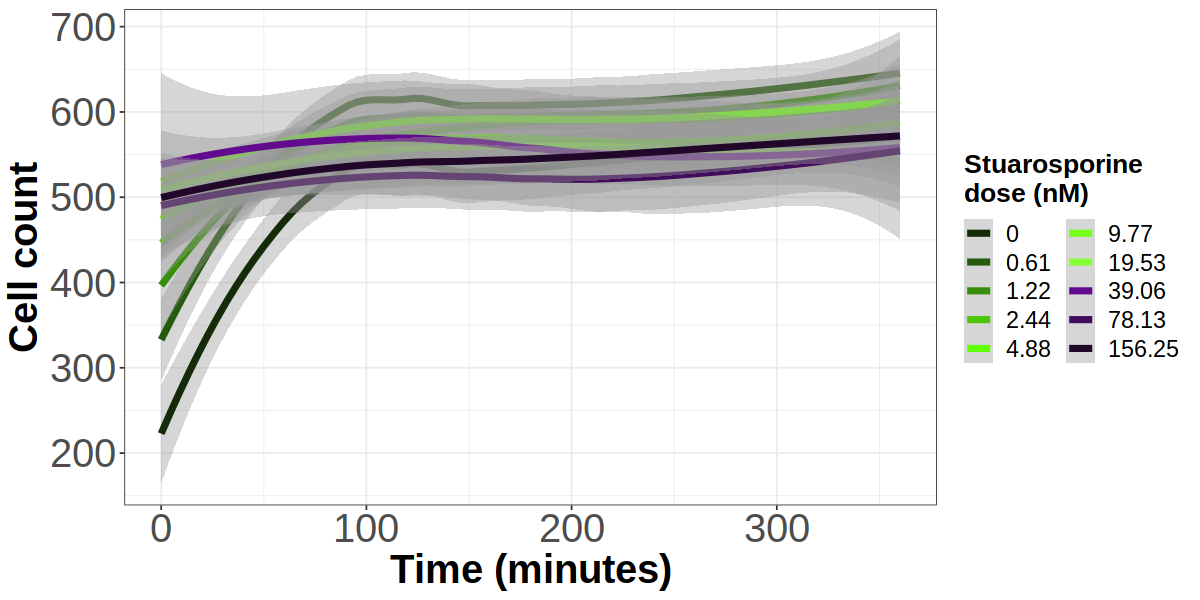

In [12]:
width <- 10
height <- 5
options(repr.plot.width = width, repr.plot.height = height)
cell_count_v_time_plot_colored_by_dose <- (
    ggplot(data = cell_count_df, aes(x = Metadata_Time, y = cell_count))
    + geom_smooth(aes(color = Metadata_dose), method = "loess", size = 2, se = TRUE, alpha = 0.4)
    + scale_color_manual(values = color_palette_dose)
    + labs(
        x = "Time (minutes)",
        y = "Cell count",
        color = "Stuarosporine\ndose (nM)",
    )
    + dose_guides_color
    + plot_themes
    # move the legend to the side
    + theme(
        legend.position = "right",
        legend.direction = "vertical",
        legend.title = element_text(size = 16, face = "bold"),
        legend.text = element_text(size = 14),
        axis.title = element_text(size = 16, face = "bold"),
        axis.text = element_text(size = 14)
    )
    + guides(color = guide_legend(ncol = 2))
    
)
cell_count_v_time_plot_colored_by_dose

## patch work a final figure

In [13]:
heatmap_grob <- grid.grabExpr(
    draw(
    heatmap_list,
    merge_legends = TRUE,
)
)


`geom_smooth()` using formula = 'y ~ x'


png 
  2

`geom_smooth()` using formula = 'y ~ x'


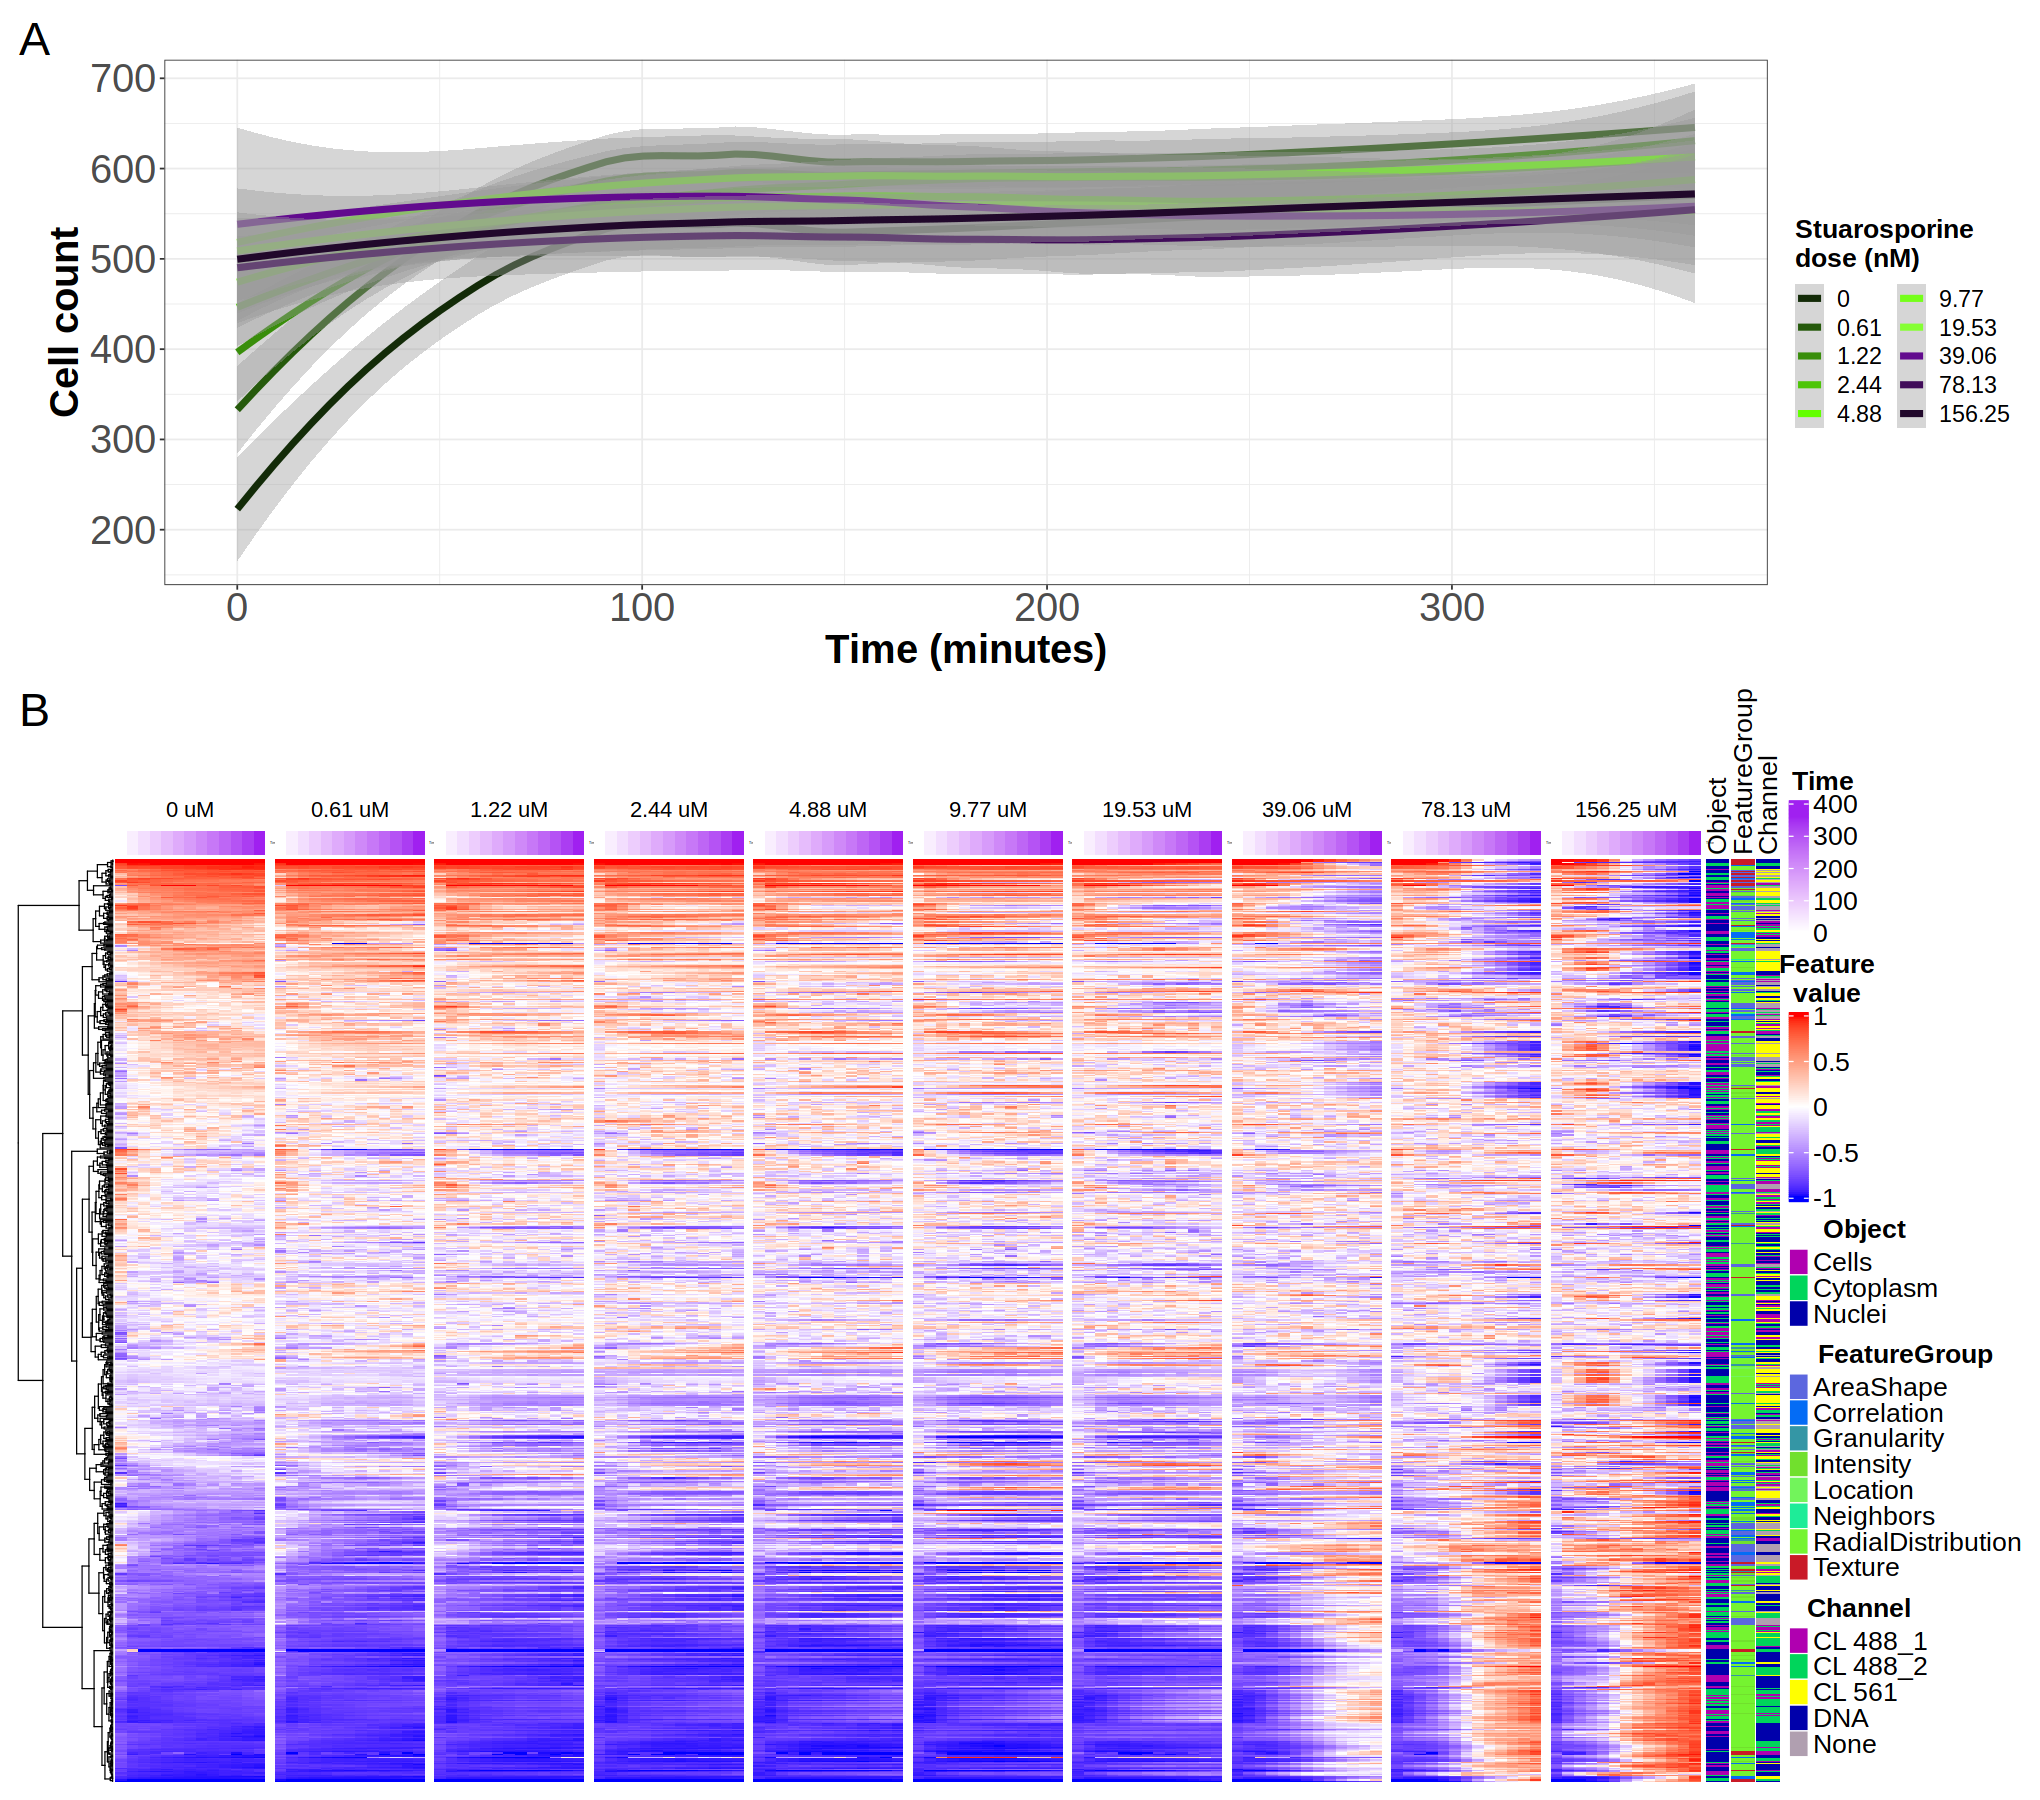

In [15]:
layout <- "
A
B
"
width <- 17
height <- 15
options(repr.plot.width = width, repr.plot.height = height)
final_figure <- (
    cell_count_v_time_plot_colored_by_dose
    # + wrap_elements(
    #     clip = TRUE,
    #     full = heatmap_grob
    #     )
    + grid.grabExpr(draw(
        heatmap_list,
        merge_legends = TRUE,
    ))
    + plot_layout(
        design = layout, 
        heights = c(0.33, 0.66)
    )
    + plot_annotation(tag_levels = 'A') & theme(plot.tag = element_text(size = 28))
)
png(filename = paste0(figure_path, "aggregate_heatmap_CP_features.png"), width = width, height = height, units = "in", res = 600)
final_figure
dev.off()
final_figure